In [27]:
# Importing libs
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame, concat
import glob
import re
from datetime import datetime
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from pandas.tools.plotting import lag_plot

In [4]:
# Checking what we are given with a sample
path = "./data"
data_test = pd.read_csv(path+"/2017-11.csv", sep=";", index_col=False)
data_test.head()

,Unnamed: 0,T_MIN,T_MAX,HAUTEUR_PRECIPITATION,DUREE_ENSOLEILLEMENT
0,1,5.0 C,13.7 C,0.0 mm,4.0 h
1,2,7.2 C,14.2 C,0.0 mm,0.8 h
2,3,10.9 C,17.0 C,0.0 mm,2.6 h
3,4,9.2 C,15.8 C,3.6 mm,0.7 h
4,5,6.7 C,10.6 C,0.0 mm,5.5 h


In [5]:
data_test.count()

Unnamed: 0               30
T_MIN                    30
T_MAX                    30
HAUTEUR_PRECIPITATION    30
DUREE_ENSOLEILLEMENT     30
dtype: int64

In [6]:
# create a list of paths reading the names of files having the extension .csv in the "path folder"
filenames = glob.glob(path + "/*.csv")

In [7]:
# data_list_title keeps track of all imported files names
data_list_title = []
for x in filenames:
    a = re.findall(r'([\w\.-]+)\.csv',x)
    data_list_title.append(a[0])
data_list_title

['2018-09',
 '2018-10',
 '2018-07',
 '2018-08',
 '2018-01',
 '2018-03',
 '2018-04',
 '2018-02',
 '2018-05',
 '2017-12',
 '2018-06',
 '2017-11']

In [8]:
# Import all files

# Empty list to store our split dataframes
data_list = []
for p in filenames:
    new = pd.read_csv(p, sep=";", index_col=None, header=0)        # load one file as a pandas df
    a = re.findall(r'([\w\.-]+)\.csv',p)                           # extract name from filename 
    yyyy = a[0].split('-')[0]                                      # extract year
    mm = a[0].split('-')[1]                                        # extract month
    d = new["Unnamed: 0"]                                          # extract day
    new["DATE"] = d.astype(str) + "-" + str(mm) + "-" + str(yyyy)  # add column DATE composed by dd-mm-yyyy
    new.rename(columns={'Unnamed: 0': 'id'}, inplace=True)         # rename empty column to id
    data_list.append(new)                                          # append df to list

# !!!! BE CAREFUL HERE !!!!!!!
# ignore_index=True allows to ignore original index of each dataset: hence resetting it globally for the new df
data = pd.concat(data_list, ignore_index=True)                     # concatenate all df together with a new index

# inplace = True changes the name in the object.
# inplace = False creates a new copy of the object with the change
data.rename(columns={'HAUTEUR_PRECIPITATION': 'H_PRECIPITATION'}, inplace=True)  # renaming
data.rename(columns={'DUREE_ENSOLEILLEMENT': 'DUREE_SOLEIL'}, inplace=True)      # renaming
data.head(5) # print 5 first list

,id,T_MIN,T_MAX,H_PRECIPITATION,DUREE_SOLEIL,DATE
0,1,12.4 C,23.5 C,0.0 mm,12.5 h,1-09-2018
1,2,12.0 C,25.2 C,0.0 mm,12.6 h,2-09-2018
2,3,14.5 C,25.3 C,0.0 mm,5.6 h,3-09-2018
3,4,17.3 C,20.3 C,0.0 mm,0.1 h,4-09-2018
4,5,18.2 C,25.9 C,0.0 mm,3.4 h,5-09-2018


In [9]:
type(data)   # checking type

pandas.core.frame.DataFrame

In [10]:
data.columns  # checking columns

Index(['id', 'T_MIN', 'T_MAX', 'H_PRECIPITATION', 'DUREE_SOLEIL', 'DATE'], dtype='object')

In [11]:
data.tail()   # checking last rows in the df

,id,T_MIN,T_MAX,H_PRECIPITATION,DUREE_SOLEIL,DATE
359,26,3.3 C,8.0 C,0.0 mm,4.1 h,26-11-2017
360,27,4.7 C,8.5 C,14.7 mm,0.2 h,27-11-2017
361,28,5.7 C,10.5 C,1.0 mm,3.6 h,28-11-2017
362,29,1.9 C,5.8 C,1.0 mm,2.6 h,29-11-2017
363,30,2.1 C,5.2 C,5.0 mm,3.0 h,30-11-2017


In [12]:
data_test_header = data.columns   # keeping columns in a variable if needed for later

In [13]:
# Data cleaning
data_clean = data.copy()
data_clean["H_PRECIPITATION"] = data["H_PRECIPITATION"].str.replace(' mm','').astype(float)    # remove mm
data_clean["T_MAX"] = data["T_MAX"].str.replace(' C','').astype(float)                         # remove C
data_clean["T_MIN"] = data["T_MIN"].str.replace(' C','').astype(float)                         # remove C
data_clean["DUREE_SOLEIL"] = data["DUREE_SOLEIL"].str.replace('h','').astype(float)            # remove h
data_clean["DATE"] = pd.to_datetime(data["DATE"],format='%d-%m-%Y')                            # format date

In [14]:
data_clean.tail(10)  # check our changes

,id,T_MIN,T_MAX,H_PRECIPITATION,DUREE_SOLEIL,DATE
354,21,7.9,10.8,0.0,0.0,2017-11-21
355,22,7.5,14.0,0.0,7.3,2017-11-22
356,23,10.7,16.8,6.7,1.7,2017-11-23
357,24,9.7,12.1,0.4,0.4,2017-11-24
358,25,4.6,7.0,0.8,1.8,2017-11-25
359,26,3.3,8.0,0.0,4.1,2017-11-26
360,27,4.7,8.5,14.7,0.2,2017-11-27
361,28,5.7,10.5,1.0,3.6,2017-11-28
362,29,1.9,5.8,1.0,2.6,2017-11-29
363,30,2.1,5.2,5.0,3.0,2017-11-30


In [16]:
# Just getting basic infos on our data
data_clean.describe()

,id,T_MIN,T_MAX,H_PRECIPITATION,DUREE_SOLEIL
count,364.000000,364.000000,364.000000,364.000000,364.000000
mean,15.678571,9.911538,17.703571,1.942857,5.384890
std,8.783812,6.261807,8.701101,5.613073,4.528121
min,1.000000,-7.000000,-1.500000,0.000000,0.000000
25%,8.000000,5.000000,10.250000,0.000000,0.900000
50%,16.000000,9.600000,17.750000,0.000000,4.900000
75%,23.000000,15.300000,25.200000,1.400000,9.100000
max,31.000000,22.400000,37.400000,78.200000,15.000000


In [17]:
# save cleaned dataframe to csv
data_clean.sort_values(by=['DATE']).reset_index(drop=True).to_csv(path+"/cleaned/paris_cleaned.csv", sep=';', encoding='utf-8')

In [18]:
data_clean_isna = data_clean.isna()          # create a temporary df with booleans if NaN

In [19]:
# create a sum of booleans
data_clean_isna.agg({"T_MIN": ["sum"],"T_MAX": ["sum"], "H_PRECIPITATION": ["sum"], "DUREE_SOLEIL": ["sum"]})

,T_MIN,T_MAX,H_PRECIPITATION,DUREE_SOLEIL
sum,0,0,0,0


In [20]:
# create a difference transform of the dataset to remove tend  # That is the derivative
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return np.append(None, np.array(diff))

difference([23,43,56,89,80])  # testing to understand how it works

array([None, 20, 13, 33, -9], dtype=object)

In [21]:
# Sort dataframe by date
# Force the index to restart from 0 after the sort, ad drop old index.
data_clean_sorted = data_clean.sort_values(by=['DATE']).reset_index(drop=True)

In [22]:
# Add the new column to our dataframe:
data_clean_sorted["T_MIN_CHANGE"] = difference(data_clean_sorted["T_MIN"])  # creating new column with differences
data_clean_sorted.head(5)                                                   # checking that our df is sorted ad our new column exists

,id,T_MIN,T_MAX,H_PRECIPITATION,DUREE_SOLEIL,DATE,T_MIN_CHANGE
0,1,5.0,13.7,0.0,4.0,2017-11-01,None
1,2,7.2,14.2,0.0,0.8,2017-11-02,2.2
2,3,10.9,17.0,0.0,2.6,2017-11-03,3.7
3,4,9.2,15.8,3.6,0.7,2017-11-04,-1.7
4,5,6.7,10.6,0.0,5.5,2017-11-05,-2.5


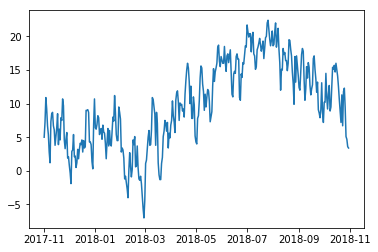

In [23]:
# plot our data as a time-series line chart (only T_MIN)
plt.plot(data_clean_sorted["DATE"], data_clean_sorted["T_MIN"])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  


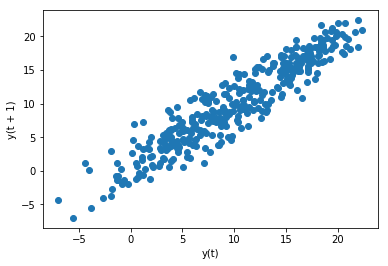

In [24]:
# Visualising correlation between T_MIN and previous day's T_MIN
lag_plot(data_clean_sorted["T_MIN"])

The linear nature of this graph shows a correlation between minimal temperatures at day t and the minimal temperature of previous day t-1.

In [34]:
data_clean_sorted = data_clean_sorted.reset_index()

data_clean_sorted.tail(8)

,index,id,T_MIN,T_MAX,H_PRECIPITATION,DUREE_SOLEIL,DATE,T_MIN_CHANGE
356,356,23,6.7,16.8,0.0,8.9,2018-10-23,-4.6
357,357,24,11.8,16.1,0.0,0.3,2018-10-24,5.1
358,358,25,12.3,15.8,0.0,4.9,2018-10-25,0.5
359,359,26,9.4,14.3,0.6,1.0,2018-10-26,-2.9
360,360,27,5.1,9.8,0.0,4.0,2018-10-27,-4.3
361,361,28,4.7,8.1,0.0,0.4,2018-10-28,-0.4
362,362,29,3.6,5.8,12.1,0.0,2018-10-29,-1.1
363,363,30,3.4,11.3,2.4,1.5,2018-10-30,-0.2


Test MSE: 7.796


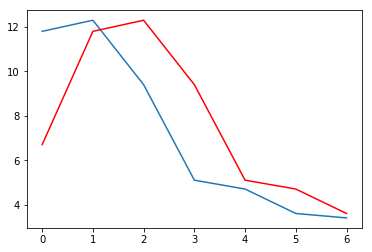

In [35]:
# Applying persistence model
# The least we can do to predict tomorrow's T_MIN is to take yesterday's T_MIN... :)
# This is called a persistence model
# This prediction will be the base to futher predictions: we should try to do better than this persistence model

dataframe = concat([data_clean_sorted_nonan["T_MIN"].shift(1), data_clean_sorted_nonan["T_MIN"]], axis=1)
dataframe.columns = ['t-1', 't+1']

X = dataframe.values

train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)

test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
plt.plot(test_y)
plt.plot(predictions, color='red')

Lag: 3
Coefficients: const       0.577709
L1.T_MIN    0.923276
L2.T_MIN   -0.072496
L3.T_MIN    0.092013
dtype: float64
predicted=11.316882, expected=6.700000
predicted=10.869609, expected=11.800000
predicted=10.832684, expected=12.300000
predicted=10.832572, expected=9.400000
predicted=10.793989, expected=5.100000
predicted=10.754978, expected=4.700000
predicted=10.721746, expected=3.600000
predicted=10.690342, expected=3.400000
Test MSE: 24.917


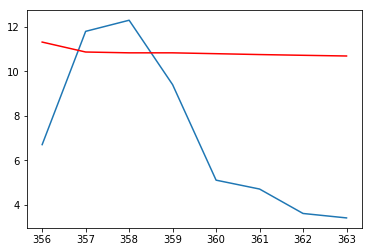

In [36]:
# Applying an autoregression model

# Splitting dataset in train vs test: keeping only last 7 days to predict 
train, test = data_clean_sorted[1:len(data_clean_sorted_nonan)-7], data_clean_sorted[len(data_clean_sorted_nonan)-7:]

window_size = 3

input_col = "T_MIN"

model = AR(train[input_col].astype(float))
model_fit = model.fit(window_size, disp=False)

print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

# Trying to predict
predictions = model_fit.predict(start=len(train[input_col]), end=len(train[input_col])+len(test[input_col])-1, dynamic=False)

for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i:i+1], test[input_col][i:i+1]))

# Calculate coefficient
error = mean_squared_error(test[input_col], predictions)
print('Test MSE: %.3f' % error)

plt.plot(test[input_col])
plt.plot(predictions, color='red')
